In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cowmontoring/cowmonitoringsystem.csv


## Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    f1_score
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


## Load and Clean Data

In [13]:
df = pd.read_csv("/kaggle/input/cowmontoring/cowmonitoringsystem.csv")

# Drop rows that are entirely empty
df = df.dropna(how='all')

# Drop constant columns and any date fields
df = df.drop(columns=[col for col in df.columns if df[col].nunique() == 1])
df = df.drop(columns=['date', 'calvdate'], errors='ignore')

# Drop the old CES column if present
df = df.drop(columns=['CES'], errors='ignore')


## Encode Categorical Features and Target Variable

In [14]:
# Categorical feature encoding
categorical_cols = df.select_dtypes(include='object').columns.tolist()
feature_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    feature_encoders[col] = le

# Encode target
target_col = 'CalvingEaseScore'
te = LabelEncoder()
df[target_col] = te.fit_transform(df[target_col].astype(str))


## Impute Missing Numeric Values

In [15]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


## Covariance Matrix Visualization

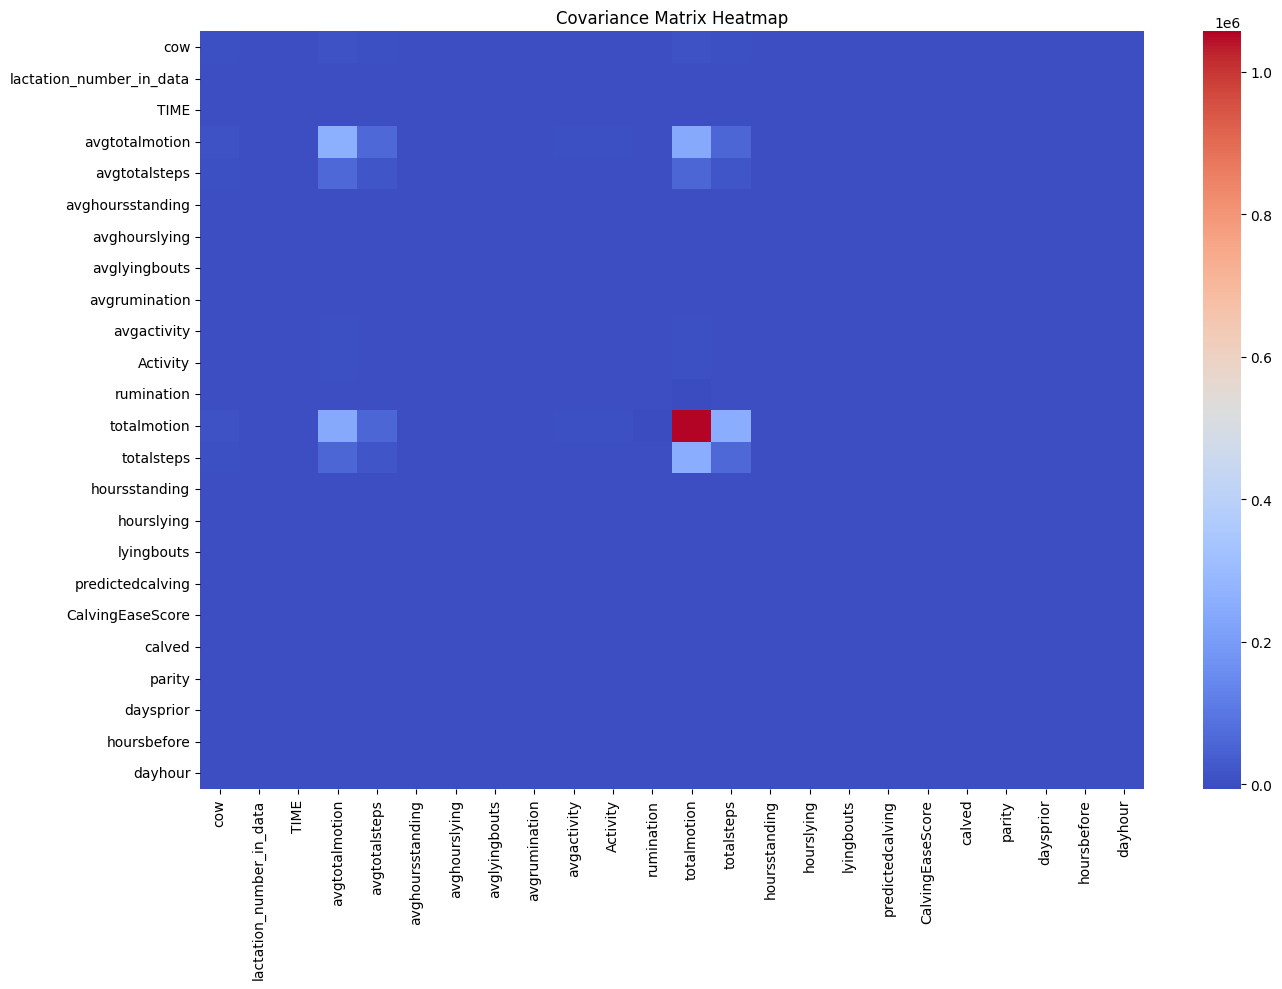

In [16]:
# ─── Covariance Matrix Heatmap ────────────────────────────────────────────────

plt.figure(figsize=(14,10))
cov_matrix = df[numeric_cols].cov()
sns.heatmap(cov_matrix, cmap='coolwarm', annot=False)
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
plt.show()


## Features Ranked by Covariance Sum (Descending)

In [18]:
# ─── Features Sorted by Total Covariance ──────────────────────────────────────

# Sum absolute covariance with all other features
cov_sum = cov_matrix.abs().sum().sort_values(ascending=False)
cov_summary = cov_sum.reset_index()
cov_summary.columns = ['Feature', 'TotalCovariance']
print("🔢 Features Ranked by Total Covariance:")
display(cov_summary.head(20))


🔢 Features Ranked by Total Covariance:


,Feature,TotalCovariance
0,totalmotion,1.632241e+06
1,avgtotalmotion,6.328651e+05
2,totalsteps,3.937687e+05
3,avgtotalsteps,1.511071e+05
4,cow,2.762060e+04
5,rumination,1.114483e+04
6,Activity,9.790154e+03
7,avgactivity,7.971179e+03
8,avgrumination,2.711087e+03
9,hoursbefore,2.656063e+03


- This ranking shows how much each feature varies across the dataset, regardless of the target. The higher the value, the more that feature varies.

### Problem:
- This tells us nothing about how each feature affects the target label (**CalvingEaseScore**).
- Features with high variance/covariance (like **totalmotion**) may not be predictive.

## Target Distribution Plot

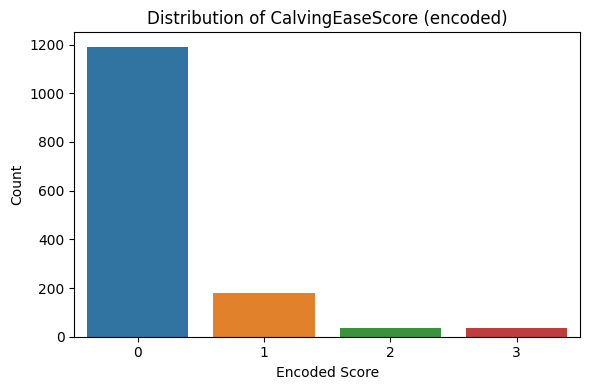

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title('Distribution of CalvingEaseScore (encoded)')
plt.xlabel('Encoded Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## Feature Engineering

In [20]:
if {'lying_time','steps'}.issubset(df.columns):
    df['lying_steps_interaction'] = df['lying_time'] * df['steps']

if {'eating_time','standing_time'}.issubset(df.columns):
    df['eat_stand_ratio'] = df['eating_time'] / (df['standing_time'] + 1e-5)

if {'rumination_time','walking_speed'}.issubset(df.columns):
    df['rum_walk_ratio'] = df['rumination_time'] / (df['walking_speed'] + 1e-5)

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()


## Train/Test Split

In [21]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print("Train class counts:", y_train.value_counts().to_dict())
print("Test  class counts:", y_test.value_counts().to_dict())


Train samples: 1154, Test samples: 289
Train class counts: {0: 952, 1: 144, 2: 29, 3: 29}
Test  class counts: {0: 239, 1: 36, 3: 7, 2: 7}


## Define and Evaluate Models

In [22]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, solver='saga'))
])

models = {
    'LogisticRegression': lr_pipeline,
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


LogisticRegression CV Accuracy: 0.8743 ± 0.0074
RandomForest CV Accuracy: 0.9827 ± 0.0099
XGBoost CV Accuracy: 0.9957 ± 0.0027


## Hyperparameter Tuning (XGBoost)

In [23]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01],
    'gamma': [0, 0.2],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    xgb, param_grid, cv=3, scoring='accuracy',
    n_jobs=-1, verbose=1, error_score='raise'
)
grid.fit(X_train, y_train)

print("\nBest XGBoost params:", grid.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best XGBoost params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


## Feature Importance & Interpretation (Top 15)

- When you train an XGBoost model, it computes feature importance based on:
- *Gain*: how much each feature improves decision splits.
- *Frequency*: how often a feature is used in the trees.
- *Coverage*: how many samples a feature split applies to.

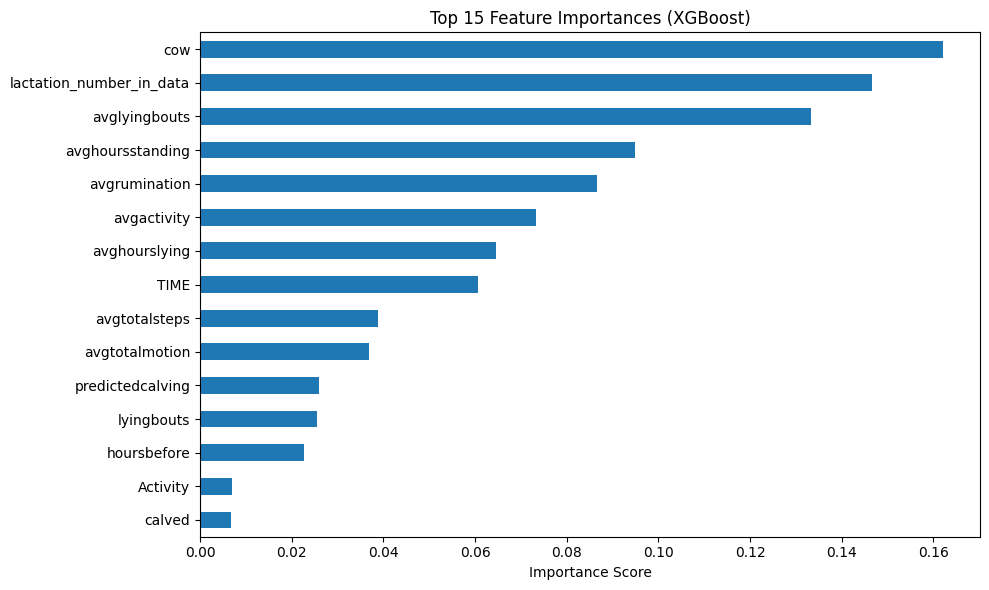

In [24]:
# ─── Top 15 Important Features via XGBoost Importance ─────────────────────────

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Get importance scores
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top15 = importances.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
top15.plot(kind='barh')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Final Evaluation

In [25]:
best = grid.best_estimator_
y_pred = best.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Weighted F1 Score:", f1_score(y_test, y_pred, average='weighted'))



Test Accuracy: 0.9896193771626297

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       239
           1       1.00      0.94      0.97        36
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         7

    accuracy                           0.99       289
   macro avg       1.00      0.95      0.97       289
weighted avg       0.99      0.99      0.99       289

Weighted F1 Score: 0.989419801184507
